In [95]:
import numpy as np
import matplotlib.pyplot as plt


from uncertainties import ufloat
import uncertainties.unumpy as unp

from scipy.optimize import curve_fit
import scipy.odr as odr

In [143]:
laserSpotHeight = [155]
platformHeightFromGround = [108]
containerHeight = [3.3]

heights = [(h1 - (h2 + h3))/100 for h1, h2, h3 in zip(laserSpotHeight, platformHeightFromGround, containerHeight)]
print(f"Height measurements: {heights}")

H = ufloat(np.mean(heights), np.std(heights)) # meters
L = 5.59 # meters

lightWavelength = 633e-9 # m
waterDensity = 998.2 # kg m^-3

grazingAngle = unp.arctan2(H, L)

rootPath = "/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/"

Height measurements: [0.43700000000000006]


In [136]:
def LoadData(path):
    data = np.loadtxt(path, skiprows=1)

    frequencies = data[:,0]
    spacings = data[:,1]/1000 # change mm to m
    spacingUncertanties = data[:,2]/1000

    spacings = np.array([ufloat(spacing, uncertainty) for spacing, uncertainty in zip(spacings, spacingUncertanties)])

    return (frequencies, spacings)

In [137]:
def GetAngularFrequencies(frequencies):
    angularFrequencies = 2 * np.pi * frequencies
    return angularFrequencies

In [138]:
def GetDiffractionAngles(spacings):
    # Input in meters will give an output in degrees

    diffractionAngles = unp.arctan2(spacings, L)

    return diffractionAngles

In [139]:
def GetWaveNumbers(diffractionAngles):
    innerBracket = unp.sin(grazingAngle + diffractionAngles / 2) + unp.sin(grazingAngle - diffractionAngles / 2)

    waveNumbers = 2 * (np.pi / lightWavelength) * unp.sin(diffractionAngles / 2) * innerBracket

    return waveNumbers

In [144]:
# De-ionised water @ room temperature

waterFrequencies, waterSpacings = LoadData(rootPath + "/water.txt")

waterAngularFrequencies = GetAngularFrequencies(waterFrequencies)

waterDiffractionAngles = GetDiffractionAngles(waterSpacings)

waterWaveNumbers = GetWaveNumbers(waterDiffractionAngles)


In [145]:
def LinearFunc(p, x):
    m, c = p
    return m * x + c

def PerformODR(function, x, y, xErr):
    model = odr.Model(function)

    data = odr.Data(x, y, wd= 1/xErr)

    odrOutput = odr.ODR(data, model, beta0=[0.03, 0])

    return odrOutput.run()

Beta: [0.05257433 0.        ]
Beta Std Error: [0.00491408 0.        ]
Beta Covariance: [[2.0805416e-15 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00]]
Residual Variance: 11606662994.497677
Inverse Condition #: 1.0
Reason(s) for Halting:
  Problem is not full rank at solution
  Sum of squares convergence


Text(0.5, 1.0, 'De-ionised Water')

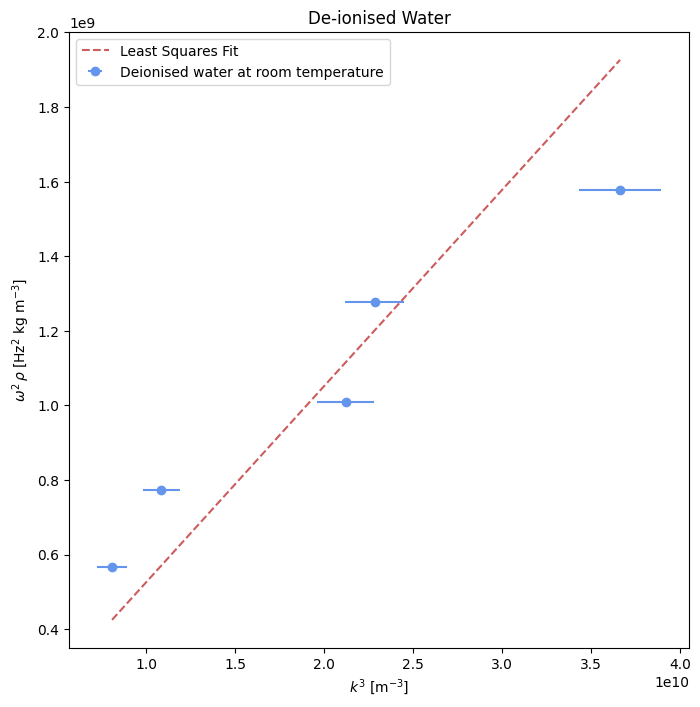

In [148]:
waterXValues = unp.nominal_values(waterWaveNumbers**3)
waterXErr = unp.std_devs(waterWaveNumbers**3)

waterYValues = unp.nominal_values(waterDensity * waterAngularFrequencies**2)
waterYErr = unp.std_devs(waterDensity * waterAngularFrequencies**2)

fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(waterXValues, waterYValues, xerr=waterXErr, fmt="o", color="cornflowerblue", label="Deionised water at room temperature")


regression = PerformODR(LinearFunc, waterXValues, waterYValues, waterXErr)
#waterPars, waterCov = curve_fit(LinearFunc, waterXValues, waterYValues, [0.03, 0])

regression.pprint()

waterXRange = np.linspace(np.min(waterXValues), np.max(waterXValues), 100)
ax.plot(waterXValues, LinearFunc(regression.beta, waterXValues), color="indianred", ls="dashed", label="Least Squares Fit")
#ax.plot(waterXValues, LinearFunc(waterXValues, waterPars[0], waterPars[1]), color="indianred", ls="dashed", label="Least Squares Fit")

ax.set_xlabel("$k^3$ [m$^{-3}$]")
ax.set_ylabel(r"$\omega^2 \,\rho$ [Hz$^2$ kg m$^{-3}$]")
ax.legend()
ax.set_title("De-ionised Water")